## 1. Key Concepts

### Binomial Pricing Formula
- The `derivative` defined in the binomial pricing formula assumes 2 scenarios at each time point (either up or down), implying a coin toss. 
- The fundamental question of binomial pricing is: *What is the value of the derivative at time zero*, before knowing whether the coin toss results in heads or tails?

### Arbitrage
1. In an efficient market, a trading strategy that yields additional wealth (from nothing to something) must assume a risk of loss.
2. An `arbitrage` trading strategy starts with no money, has zero probability of losing money, and has a positive probability of making money.

### Arbitrage Pricing
- The `arbitrage pricing theory` approach to option-pricing problems replicates the option by trading in the stock and money markets to eliminate arbitrage opportunities.

### Risk-Neutral Binomial Pricing Model
The risk-neutral binomial pricing model was developed by hedging between two strategies:
1. **Long/short a call option** with a target pricing value \(V\).
2. **Short/long a portfolio** consisting of \(h\) stocks and money market instruments.

To perfectly hedge, we find \(V\) and \(h\) such that the payoffs of both strategies in both scenarios (up or down) are the same, which is why it's called risk-neutral hedging. Since a perfectly hedged portfolio is assumed, the proper expected return should be the **risk-free rate**.

### General Pricing Formula
The general pricing formula is:
$$
E(V, n) = \frac{E(V, N)}{(1 + r)^{(N - n)}}
$$
Where:
- E(V, n) is the expected payoff of the derivative (or asset) at time n.
- E(V, N) is the expected payoff at time N. It is discounted back to n using the risk-free rate r.

For binomial models, the expected value at time \(N\) is given by:
$$
E(V, N) = p \cdot E(V, N, \text{up}) + (1 - p) \cdot E(V, N, \text{down})
$$

Where \(p\) represents the probability of an "up" movement.

#### Two Perspectives:
1. **Risk-Neutral (Market Maker)**: Find $$\tilde{p}$$ and $$\tilde{q} = 1 - \tilde{p}$$ such that no arbitrage exists.
2. **Fund Manager**: Predict the actual probabilities p and q = 1 - p to adjust for the risky asset position.

### Risk-Neutral Binomial Pricing Model
- **u**: Up factor, **d**: Down factor (common assumption is d < u, and d = 1/u).
- **S**: Stock price.
- **h**: Hedging ratio (implies stock position).
- The probability of an up or down movement is not necessarily 50-50.
- **Risk-free rate**: \(r > -1\) is sufficient.

#### Arbitrage Condition:
$$
0 < d < 1 + r < u
$$

#### Risk-Neutral Probabilities:
$$
\tilde{p} = \frac{1 + r - d}{u - d}, \quad \tilde{q} = 1 - \tilde{p}
$$

#### Hedge Ratio:
$$
h = \frac{V_u - V_d}{S_u - S_d}
$$

Where Vu and Vd are the option values in the up and down scenarios, and Su and Sd are the stock prices in those scenarios.

## Writing Iterations for the Binomial Tree

### Stock Prices
Set the initial stock price as S0. At each point, we have the stock price as:

$$
S_0 \cdot u^i \cdot d^j
$$

By trying some patterns, we can write nested loops where i ranges from 1 to T, and j ranges from 0 to i + 1. The general formula for stock prices is:

$$
S_0 \cdot u^{(i - j)} \cdot d^j
$$

For example, when T = 1, then i = 1, and j ranges over (0, 1), i.e. j = 0 and j = 1. The stock prices will be:

$$
S_0 \cdot u^1 \cdot d^0 = S_0 \cdot u \quad \text{and} \quad S_0 \cdot u^0 \cdot d^1 = S_0 \cdot d
$$

### Option Payoffs
- If we need to valuate option at time t, then we need to calculate its payoffs at t + 1 for each scenario, followed by taking the expected value using the risk-neutral probability, and finally discounted back to t using the risk-free rate.
- At time t + 1, the **call option payoff** is:

$$
\max(0, St+1 - K)
$$

- The **put option payoff** is:

$$
\max(0, K - St+1)
$$

- We iterate through the stock prices list and apply these formulas for both cases (call and put).

### Option Valuation
- Solving the binomial tree is similar to solving a decision tree: we work from the right (maturity) to the left (time 0). Thus, we need a backward loop from T back to time 0, decreasing by 1 at each step.
  
- Since Python uses zero-indexing, for example, if T = 5, the loop goes as (4, 3, 2, 1, 0).
  
- Using the formula above, we calculate the option value at each point. Note that the corresponding list index for each point is j.

### American Options
- For American options, which give the right to exercise early, we need an additional step: comparing the calculated option value to its **intrinsic value** at that time t.
- The intrinsic value is basically the option payoff:
    - **For calls**: Max(0, St - K)
    - **For puts**: Max(0, K - St)

- We choose the higher value for further backward iteration.

### Remaining Steps
- Display the results.
- Plot the binomial tree if needed. In this case, we can create a simple tree graph to visualize the stock prices and option values.s.

## 2. Working with codes

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import math

def binomial_option_pricing(S0, K, u, d, r, T, option_type="call", option_style="european", plot=True):
    """
    Calculate and optionally plot the European or American option price using a binomial tree.

    Parameters:
    S0 (float): Initial stock price
    K (float): Strike price
    u (float): Up factor
    d (float): Down factor
    r (float): Risk-free interest rate per period
    T (int): Number of periods
    option_type (str): "call" for call option, "put" for put option
    option_style (str): "european" or "american" for option style
    plot (bool): Whether to plot the binomial tree (default is True)

    Returns:
    float: Option price
    """
    # Calculate the risk-neutral probability
    p = ( 1+ r - d) / (u - d)
    
    # Generate the stock price tree
    stock_price_tree = [[S0]]
    for i in range(1, T + 1):
        level = []
        for j in range(i + 1):
            level.append(S0 * (u ** (i - j)) * (d ** j))
        stock_price_tree.append(level)
    
    # Calculate the option payoff at maturity
    option_payoff_tree = []
    if option_type == "call":
        option_payoff_tree.append([max(price - K, 0) for price in stock_price_tree[-1]])
    elif option_type == "put":
        option_payoff_tree.append([max(K - price, 0) for price in stock_price_tree[-1]])
    
    # Initialize hedging ratios tree
    hedging_ratios = []

    # Work backwards through the tree to calculate option prices and hedging ratios
    for i in range(T - 1, -1, -1):
        Vt = []
        h_level = []  # Store hedging ratios for this level
        for j in range(i + 1):
            # Risk-neutral expected value (continuous compounding discount factor)
            value = ( (p * option_payoff_tree[0][j] + (1 - p) * option_payoff_tree[0][j + 1]) ) / (1 + r)
            
            if option_style == "american":
                # Check for early exercise (only relevant for American options)
                if option_type == "call":
                    value = max(value, stock_price_tree[i][j] - K)  # Early exercise for call option
                elif option_type == "put":
                    value = max(value, K - stock_price_tree[i][j])  # Early exercise for put option
            
            Vt.append(value)
            
            # Calculate hedging ratio (delta)
            S_u = stock_price_tree[i + 1][j]
            S_d = stock_price_tree[i + 1][j + 1]
            V_u = option_payoff_tree[0][j]
            V_d = option_payoff_tree[0][j + 1]
            h = (V_u - V_d) / (S_u - S_d)
            h_level.append(h)
        
        option_payoff_tree.insert(0, Vt)
        hedging_ratios.insert(0, h_level)

    # Plot the binomial tree if plot=True
    if plot:
        plot_binomial_tree(stock_price_tree, option_payoff_tree, hedging_ratios, T)
    
    # Print the option price with the desired format
    print(f'The binomial option price ({option_type}, {option_style}) with {T} steps is {round(option_payoff_tree[0][0], 6)}')
    
    return option_payoff_tree[0][0]


def plot_binomial_tree(stock_price_tree, option_payoff_tree, hedging_ratios, T):
    """
    Plot the binomial tree for stock prices and option values, including hedging ratios.

    Parameters:
    stock_price_tree (list): The binomial tree of stock prices.
    option_price_tree (list): The binomial tree of option values.
    hedging_ratios (list): The binomial tree of hedging ratios (delta values).
    T (int): Number of periods in the tree.
    """
    G = nx.DiGraph()  

    # Add nodes and edges for the binomial tree
    pos = {}
    labels = {}

    # Iterate throughout thee tree
    for i in range(T + 1):  # Loop over each level in the tree (0 to T)
        for j in range(i + 1):  # Loop over nodes in each level
            # Create a unique identifier for each node
            node = f"S{i}{j}"
            # Add nodes (stock price, option price, hedging ratio) at each step
            G.add_node(node)
            
            # Store positions for plotting
            pos[node] = (i, -j + i / 2.0)  # Adjust y-position for visual balance
            if i < T:
                labels[node] = f"S: {stock_price_tree[i][j]:.2f}\nOpt: {option_payoff_tree[i][j]:.2f}\nh: {hedging_ratios[i][j]:.2f}"
            else:
                labels[node] = f"S: {stock_price_tree[i][j]:.2f}\nOpt: {option_payoff_tree[i][j]:.2f}"
            
            # Add edges to connect the nodes, creating the tree structure
            if i > 0:  # If not the first level, add edges to previous level
                if j < i:
                    G.add_edge(f"S{i-1}{j}", node)  # Connect from upper level (up move)
                if j > 0:
                    G.add_edge(f"S{i-1}{j-1}", node)  # Connect from upper level (down move)

    # Plot the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000, node_color="lightblue", 
            font_size=9, font_weight='bold', font_color="darkblue", edge_color="gray", arrows=False)
    plt.title(f"Binomial Tree for Stock Price, Option Payoff, and Hedging Ratio (T = {T})", fontsize=14, color="darkred")
    plt.grid(True, alpha = 0.3)
    plt.show()

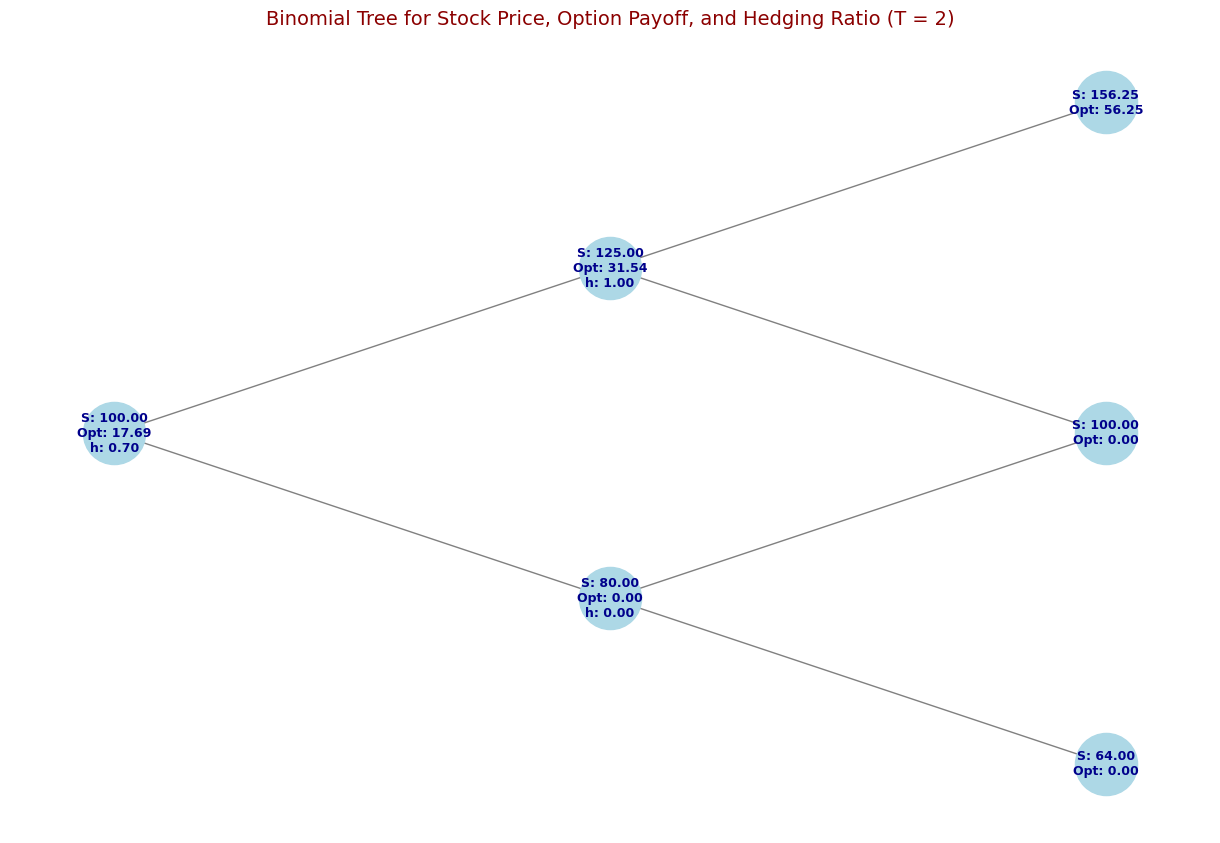

The binomial option price (call, european) with 2 steps is 17.687134


In [18]:
# Example 
S0 = 100  # Initial stock price
K = 100  # Strike price
u = 1.25   # Up factor
d = 0.8 # Down factor
r = 0.07  # Risk-free interest rate
T = 2     # Number of periods

# Call the function for an American call option and print the result
call_valuation = binomial_option_pricing(S0, K, u, d, r, T, option_type="call", option_style="european", plot=True)

## 3. Implementing Hedging Using the Binomial Model Results

* Suppose we want to hedge a short position of 1 call option.
* We begin with an initial wealth of \$17.69.
* Using the hedge ratio of 0.70, we need to long 0.70 shares of stock for each call shorted. With the stock price at t0 is $100, the stock position value is:

$$
0.70 \times 100 = 70
$$

* The shortage of cash can be financed by the money market, i.e., a debt of \$52.31 at a cost of 7%.
* The value of our hedging portfolio at t0 is:

$$
70 - 52.31 = 17.69
$$

which is the initial wealth.

#### At time t1:

1. **For the call shorted**: The payoff is either $31.54 or 0 for the up or down case, respectively. To verify our hedging position, we need the portfolio position to yield the equivalent payoffs in both scenarios.

2. **For the hedging portfolio**: The total debt is now:

$$
52.31 \times 1.07 = 55.97
$$

a) **For the up case**, the value of the position is:

$$
0.70 \times 125 - 55.97 \approx 31.54
$$

b) **For the down case**, the value of the position is:

$$
0.70 \times 80 - 55.97 \approx 0
$$

These confirm that we have replicated the call payoff, hence perfectly hedging the short call position.

#### Maintaining the Hedging Position:

To maintain this hedging position from t1 to t2, we need to rebalance the portfolio using the updated hedge ratio.

1. If the first move is **up**, then h = 1. This means that for every call shorted, we need to long 1 stock.
2. If the first move is **down**, then h = 0. This means that for every call shorted, we need to clear our long stock position.


#### Proving Risk-Free Return

* Since the hedging portfolio perfectly matches the payoffs of the short call in both up and down scenarios, the strategy has no remaining risk. Now, let's examine the initial wealth and final wealth:

1. **Initial wealth**: 17.69 (after borrowing 52.31 and longing 0.70 shares of stock).

2. **Final wealth**: After hedging, the portfolio earns the same amount as the risk-free rate, since there is no risk left in the portfolio. The debt was borrowed at a cost of 7%, and the final payoff from the portfolio is exactly sufficient to cover this interest. This shows that the strategy yields a risk-free return.

* Since we started with 17.69, borrowed 52.31, and the interest cost was 7%, we earn exactly 7% on the initial position, matching the risk-free rate. Thus, the strategy replicates the payoff of a risk-free bond with a return of 7%.

## 4. Try the code on longer period

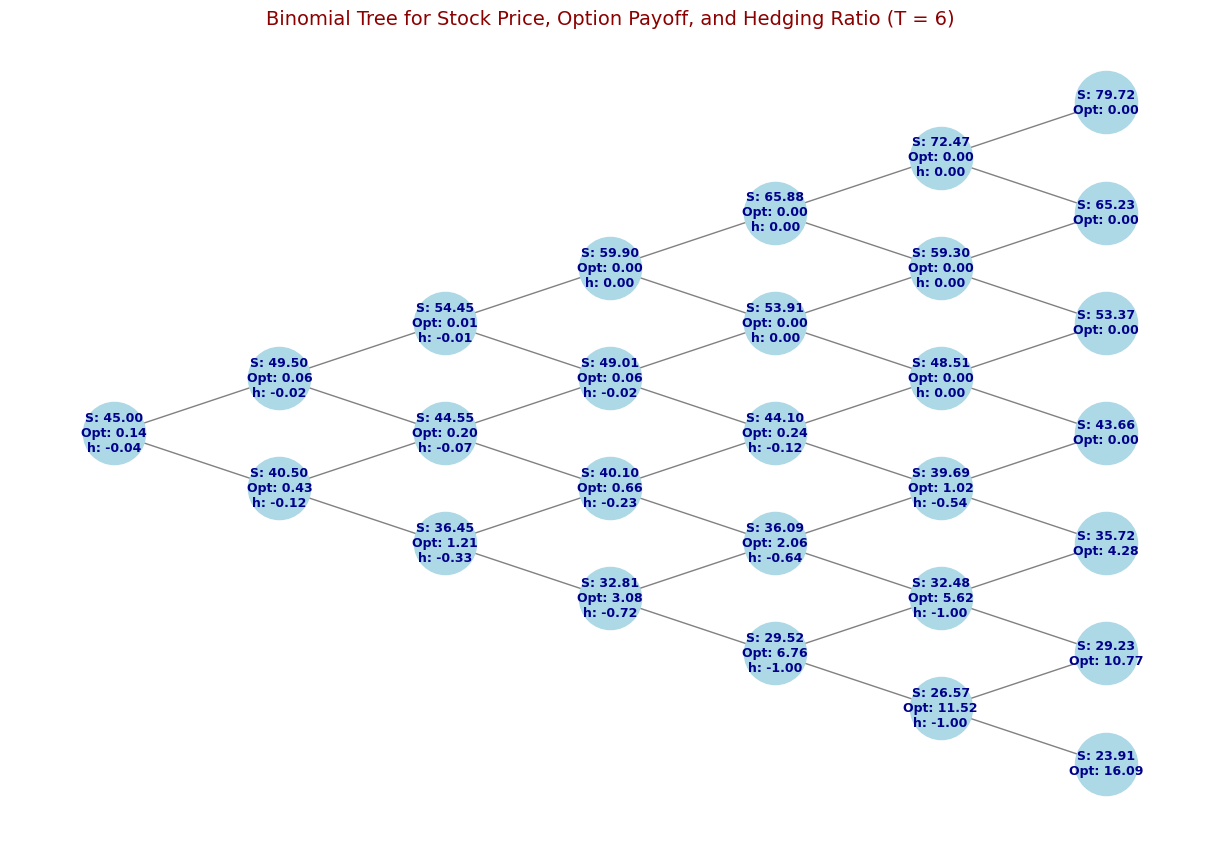

The binomial option price (put, european) with 6 steps is 0.143401


In [22]:
# Example 
S0 = 45 
K = 40
u = 1.1
d = 0.9 
r = 0.05 
T = 6

# Call the function for an American call option and print the result
put_valuation = binomial_option_pricing(S0, K, u, d, r, T, option_type="put", option_style="european", plot=True)

* More practice can be done by extending the ideas into more periods for further understanding.
* More practice can be done by working on tri-nomial trees.
* Further visualization can be done for more detail.